In [61]:
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import xgboost as xgb

import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder


# Input the data

## load dataset (clinical_info)

In [62]:
folder_path = Path('../data/Shanghai_diabetes_datasets/clinical_info/csv')

if not os.path.exists(folder_path):
    raise FileNotFoundError(f"directory {folder_path} doesn't exist")

df1 = pd.read_csv(folder_path.joinpath('Shanghai_T1DM_Summary.csv'))
df2 = pd.read_csv(folder_path.joinpath('Shanghai_T2DM_Summary.csv'))

combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df.head(9)

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no),Comorbidities
0,1001_0_20210730,1,66,1.50,60,26.67,0.0,non-drinker,T1DM,10.00,...,3.59,1.02,0.86,2.01,37.3,160,188.86,6.47,no,"hypertension, osteoporosis, thyroid nodule, pu..."
1,1002_0_20210504,2,68,1.70,63,21.80,50.0,drinker,T1DM,26.00,...,4.78,2.2,0.93,3.28,66.8,109,342.57,6.05,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
2,1002_1_20210521,2,68,1.70,67,23.18,50.0,drinker,T1DM,26.00,...,4.78,2.2,0.93,3.28,69.4,104,322.18,3.06,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
3,1002_2_20210909,2,68,1.70,65,22.49,50.0,drinker,T1DM,26.00,...,3.49,1.82,0.84,1.83,63.7,115,342.34,6.21,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
4,1003_0_20210831,2,37,1.90,60,16.62,0.0,non-drinker,T1DM,0.08,...,5.61,1.14,1.08,3.95,49.6,174,93.39,1.85,yes,"leucopenia, hypokalemia, hepatic dysfunction"
5,1004_0_20210425,1,67,1.55,47,19.56,0.0,non-drinker,T1DM,12.00,...,4.57,0.91,1.27,2.76,45.2,127,240.61,3.98,yes,"hypocalcemia, thyroid nodule, osteoporosis"
6,1005_0_20210522,2,58,1.70,50,17.30,22.5,non-drinker,T1DM,16.00,...,4.05,0.46,1.57,2.12,75.4,98,205.48,3.96,yes,"thyroid nodule, prostatic hyperplasia, osteopo..."
7,1006_0_20210114,2,57,1.61,53,20.52,0.0,non-drinker,T1DM,7.00,...,4.44,0.68,1.97,2.57,74.0,97,247.00,6.40,yes,none
8,1006_1_20210209,2,57,1.61,52,20.18,0.0,non-drinker,T1DM,7.00,...,5.12,0.64,1.88,2.93,82.0,91,257.00,6.40,yes,none


## handling missing values

In [63]:
combined_df.replace('/', pd.NA, inplace=True)  # convert / to null

cols_to_fill = [
    'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
    'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
    '2-hour Postprandial Plasma Glucose (mg/dl)', 'Fasting C-peptide (nmol/L)',
    '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
    '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
    'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
    'High-Density Lipoprotein Cholesterol (mmol/L)', 'Low-Density Lipoprotein Cholesterol (mmol/L)',
    'Creatinine (umol/L)', 'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
    'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)'
]

for col in cols_to_fill:
    if col in combined_df.columns:
        combined_df[col] = pd.to_numeric(combined_df[col].astype(str).str.strip(), errors='coerce')

combined_df[cols_to_fill] = combined_df[cols_to_fill].fillna(combined_df[cols_to_fill].median())

## analyse data

In [64]:
combined_df.describe()

,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Duration of Diabetes (years),Fasting Plasma Glucose (mg/dl),2-hour Postprandial Plasma Glucose (mg/dl),Fasting C-peptide (nmol/L),...,HbA1c (mmol/mol),Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L)
count,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,...,125.00000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000
mean,1.544000,60.136000,1.655120,65.216000,23.72184,4.533600,9.059680,168.346080,263.586240,0.400936,...,75.14400,24.428000,4.785280,1.670960,1.159600,3.072320,63.012000,116.76000,320.734320,5.831440
std,0.500065,13.547017,0.094627,11.984253,3.46806,13.181143,8.399958,65.815955,84.357438,0.264888,...,26.50919,8.869616,0.990184,0.966817,0.352924,0.894042,18.655301,40.02608,89.379685,1.698329
min,1.000000,22.000000,1.420000,35.000000,13.67000,0.000000,0.010000,55.800000,72.540000,0.007000,...,23.00000,7.100000,2.510000,0.460000,0.690000,0.980000,22.600000,34.00000,93.390000,1.810000
25%,1.000000,52.000000,1.600000,56.000000,21.89000,0.000000,1.000000,124.920000,212.580000,0.230000,...,55.00000,19.500000,4.270000,1.080000,0.930000,2.520000,52.400000,99.00000,262.400000,5.210000
50%,2.000000,62.000000,1.650000,65.000000,23.44000,0.000000,7.000000,158.400000,256.320000,0.370000,...,68.00000,22.400000,4.690000,1.540000,1.080000,3.080000,62.800000,108.00000,317.030000,5.600000
75%,2.000000,68.000000,1.720000,72.000000,25.30000,0.000000,15.000000,194.400000,304.200000,0.500000,...,93.00000,28.200000,5.310000,1.810000,1.290000,3.690000,70.400000,126.00000,355.960000,6.400000
max,2.000000,97.000000,1.900000,100.000000,36.73000,80.000000,40.000000,432.000000,610.380000,1.240000,...,166.00000,71.100000,7.790000,7.650000,2.560000,5.270000,136.100000,286.00000,563.960000,15.580000


## handling duplicates

In [65]:
duplicate_rows_data = combined_df[combined_df.duplicated()]
print('duplicate_rows_data', duplicate_rows_data)

duplicate_rows_data Empty DataFrame
Columns: [Patient Number, Gender (Female=1, Male=2), Age (years), Height (m), Weight (kg), BMI (kg/m2), Smoking History (pack year), Alcohol Drinking History (drinker/non-drinker), Type of Diabetes, Duration of Diabetes (years), Acute Diabetic Complications, Diabetic Macrovascular  Complications, Diabetic Microvascular Complications, Hypoglycemic Agents, Other Agents, Fasting Plasma Glucose (mg/dl), 2-hour Postprandial Plasma Glucose (mg/dl), Fasting C-peptide (nmol/L), 2-hour Postprandial C-peptide (nmol/L), Fasting Insulin (pmol/L), 2-hour Postprandial Insulin (pmol/L), HbA1c (mmol/mol), Glycated Albumin (%), Total Cholesterol (mmol/L), Triglyceride (mmol/L), High-Density Lipoprotein Cholesterol (mmol/L), Low-Density Lipoprotein Cholesterol (mmol/L), Creatinine (umol/L), Estimated Glomerular Filtration Rate  (ml/min/1.73m2), Uric Acid (mmol/L), Blood Urea Nitrogen (mmol/L), Hypoglycemia (yes/no), Comorbidities]
Index: []

[0 rows x 33 columns]


## uniqueness

In [66]:
for column in combined_df.columns:
    unique_value = len(combined_df[column].unique())
    print(f'{column}: {unique_value} quantity unique value')

Patient Number: 125 quantity unique value
Gender (Female=1, Male=2): 2 quantity unique value
Age (years): 45 quantity unique value
Height (m): 35 quantity unique value
Weight (kg): 42 quantity unique value
BMI (kg/m2): 100 quantity unique value
Smoking History (pack year): 15 quantity unique value
Alcohol Drinking History (drinker/non-drinker): 2 quantity unique value
Type of Diabetes: 2 quantity unique value
Duration of Diabetes (years): 36 quantity unique value
Acute Diabetic Complications: 2 quantity unique value
Diabetic Macrovascular  Complications: 8 quantity unique value
Diabetic Microvascular Complications: 8 quantity unique value
Hypoglycemic Agents: 78 quantity unique value
Other Agents: 70 quantity unique value
Fasting Plasma Glucose (mg/dl): 81 quantity unique value
2-hour Postprandial Plasma Glucose (mg/dl): 96 quantity unique value
Fasting C-peptide (nmol/L): 62 quantity unique value
2-hour Postprandial C-peptide (nmol/L): 59 quantity unique value
Fasting Insulin (pmol/L)

## emissions

In [67]:
for col in cols_to_fill:
    q1 = combined_df[col].quantile(0.25)
    q3 = combined_df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = combined_df[(combined_df[col] < lower) | (combined_df[col] > upper)]
    print(f'{col}: {len(outliers)} emissions')

Age (years): 2 emissions
Height (m): 1 emissions
Weight (kg): 2 emissions
BMI (kg/m2): 7 emissions
Smoking History (pack year): 22 emissions
Duration of Diabetes (years): 1 emissions
Fasting Plasma Glucose (mg/dl): 7 emissions
2-hour Postprandial Plasma Glucose (mg/dl): 5 emissions
Fasting C-peptide (nmol/L): 8 emissions
2-hour Postprandial C-peptide (nmol/L): 24 emissions
Fasting Insulin (pmol/L): 12 emissions
2-hour Postprandial Insulin (pmol/L): 62 emissions
HbA1c (mmol/mol): 1 emissions
Glycated Albumin (%): 5 emissions
Total Cholesterol (mmol/L): 5 emissions
Triglyceride (mmol/L): 10 emissions
High-Density Lipoprotein Cholesterol (mmol/L): 10 emissions
Low-Density Lipoprotein Cholesterol (mmol/L): 0 emissions
Creatinine (umol/L): 7 emissions
Estimated Glomerular Filtration Rate  (ml/min/1.73m2): 17 emissions
Uric Acid (mmol/L): 7 emissions
Blood Urea Nitrogen (mmol/L): 14 emissions


## correction emissions

In [68]:
combined_df = combined_df[combined_df['Fasting Insulin (pmol/L)'] < 700]
combined_df = combined_df[combined_df['2-hour Postprandial Insulin (pmol/L)'] < 800]

In [69]:
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no),Comorbidities
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,no,"hypertension, osteoporosis, thyroid nodule, pu..."
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,yes,"hypertension, hypokalemia, hyperlipidemia, chr..."
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,yes,"leucopenia, hypokalemia, hepatic dysfunction"


## drop unused columns

In [70]:
combined_df = combined_df.drop(columns=[
    'Hypoglycemic Agents', 'Comorbidities', 'Other Agents', 'Diabetic Macrovascular  Complications',
    'Diabetic Microvascular Complications', 'Acute Diabetic Complications'])

In [71]:
combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no)
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,non-drinker,T1DM,10.00,...,40.7,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,no
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,drinker,T1DM,26.00,...,19.6,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,yes
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,drinker,T1DM,26.00,...,19.6,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,yes
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,drinker,T1DM,26.00,...,25.1,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,yes
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,non-drinker,T1DM,0.08,...,46.6,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,yes


## encoding columns Alcohol Drinking History (drinker/non-drinker) and Hypoglycemia (yes/no)

Hypoglycemia (yes/no) -> (yes 1 / no 0)
Alcohol Drinking History (drinker/non-drinker) -> (yes 0 / no 1)

In [72]:
label_encoder = preprocessing.LabelEncoder()

for col_to_encode in ['Alcohol Drinking History (drinker/non-drinker)', 'Hypoglycemia (yes/no)', 'Type of Diabetes']:
    combined_df[col_to_encode] = label_encoder.fit_transform(combined_df[col_to_encode])

combined_df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),Hypoglycemia (yes/no)
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,0,10.00,...,40.7,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,0,26.00,...,19.6,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,1
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,0,26.00,...,19.6,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,1
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,0,26.00,...,25.1,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,1
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,0,0.08,...,46.6,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,1


## rename Hypoglycemia (yes/no)

In [73]:
combined_df[f'has_hypoglycemia'] = combined_df['Hypoglycemia (yes/no)']

In [74]:
df = combined_df.drop(columns=['Hypoglycemia (yes/no)'])
df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Glycated Albumin (%),Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),has_hypoglycemia
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,0,10.00,...,40.7,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,0
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,0,26.00,...,19.6,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,1
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,0,26.00,...,19.6,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,1
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,0,26.00,...,25.1,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,1
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,0,0.08,...,46.6,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,1


In [75]:
df.columns

Index(['Patient Number', 'Gender (Female=1, Male=2)', 'Age (years)',
       'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
       'Smoking History (pack year)',
       'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
       'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
       '2-hour Postprandial Plasma Glucose (mg/dl)',
       'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)',
       'Fasting Insulin (pmol/L)', '2-hour Postprandial Insulin (pmol/L)',
       'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
       'Total Cholesterol (mmol/L)', 'Triglyceride (mmol/L)',
       'High-Density Lipoprotein Cholesterol (mmol/L)',
       'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
       'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)',
       'Uric Acid (mmol/L)', 'Blood Urea Nitrogen (mmol/L)',
       'has_hypoglycemia'],
      dtype='object')

# indicating therapy_type

In [76]:
folder_Shanghai_T1DM = Path('../data/Shanghai_diabetes_datasets/Shanghai_CSV-Data/first_type')
folder_Shanghai_T2DM = Path('../data/Shanghai_diabetes_datasets/Shanghai_CSV-Data/second_type')

## converting check

In [77]:
folder_excel = Path('../data/Shanghai_diabetes_datasets/Shanghai_T2DM/')
folder_csv = Path('../data/Shanghai_diabetes_datasets/Shanghai_CSV-Data/second_type')

excel_names = {file.stem for file in folder_excel.glob('*.xlsx')} | \
              {file.stem for file in folder_excel.glob('*.xls')}

csv_names = {f.stem for f in folder_csv.glob('*.csv')}

missing_converted = excel_names - csv_names

if missing_converted:
    print("The following Excel files were not converted to CSV:")
    for name in sorted(missing_converted):
        print(name + ' (missing .csv)')
else:
    print("All Excel files were successfully converted to CSV.")

All Excel files were successfully converted to CSV.


## determine_treatment

In [78]:
def determine_treatment(file_path):
    df = pd.read_csv(file_path)
    treatments = []

    if 'Insulin dose - s.c.' in df.columns and df['Insulin dose - s.c.'].dropna().astype(str).str.strip().ne('').any():
        treatments.append('s.c. insulin')

    if 'Insulin dose - i.v.' in df.columns and df['Insulin dose - i.v.'].dropna().astype(str).str.strip().ne('').any():
        treatments.append('i.v. insulin')

    if 'CSII - bolus insulin (Novolin R, IU)' in df.columns and df[
        'CSII - bolus insulin (Novolin R, IU)'].dropna().astype(str).str.strip().ne('').any():
        treatments.append('CSII bolus')

    if 'CSII - basal insulin (Novolin R, IU / H)' in df.columns and df[
        'CSII - basal insulin (Novolin R, IU / H)'].dropna().astype(str).str.strip().ne('').any():
        treatments.append('CSII basal')

    if 'Non-insulin hypoglycemic agents' in df.columns and df['Non-insulin hypoglycemic agents'].dropna().astype(
            str).str.strip().ne('').any():
        treatments.append('non-insulin agents')

    return '; '.join(treatments)

In [79]:
treatment_map_1 = {}
treatment_map_2 = {}

for file in folder_Shanghai_T1DM.glob('*.csv'):
    for patient_id in df['Patient Number']:
        if patient_id in file.name:
            treatment_map_1[patient_id] = determine_treatment(file)
            break

for file in folder_Shanghai_T2DM.glob('*.csv'):
    for patient_id in df['Patient Number']:
        if patient_id in file.name:
            treatment_map_2[patient_id] = determine_treatment(file)
            break

treatment_map = {**treatment_map_1, **treatment_map_2}

df['treatment'] = df['Patient Number'].map(treatment_map)
df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),has_hypoglycemia,treatment
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,0,10.00,...,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,0,CSII bolus; CSII basal; non-insulin agents
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,0,26.00,...,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,1,s.c. insulin; i.v. insulin; CSII bolus; CSII b...
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,0,26.00,...,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,1,s.c. insulin; CSII bolus; CSII basal
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,0,26.00,...,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,1,CSII bolus; CSII basal
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,0,0.08,...,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,1,s.c. insulin; i.v. insulin; CSII bolus; CSII b...


## deleted null treatment

In [80]:
df = df[df['treatment'].notna()]

# folder_path = Path('../data/Shanghai_diabetes_datasets/3_step_finish_dataset/3_step_finish_dataset.csv')
# df.to_csv(folder_path)

## grouped non-insulin, insulin treatment or mixed

In [81]:
def classify_treatment(df):
    insulin_treatments = {'CSII bolus', 'CSII basal', 's.c. insulin', 'i.v. insulin'}
    non_insulin_treatment = 'non-insulin agents'

    def classify(row):
        treatments = set([value.strip() for value in row.split(';')])

        has_insulin = bool(treatments.intersection(insulin_treatments))
        has_non_insulin = non_insulin_treatment in treatments

        if has_insulin and has_non_insulin:
            return 'mixed_treatment'
        elif has_insulin:
            return 'insulin_treatment'
        elif has_non_insulin:
            return 'drug_treatment'
        else:
            return None

    df['treatment_type'] = df['treatment'].apply(classify)

    df = df.dropna(subset=['treatment_type'])

    return df


df = classify_treatment(df)
folder_path = Path('../data/Shanghai_diabetes_datasets/3_step_finish_dataset/3_step_finish_dataset.csv')
df.to_csv(folder_path)

In [82]:
df = df.drop(['treatment'], axis=1)

## encoding columns treatment_type

In [83]:
# label_encoder = preprocessing.LabelEncoder()
#
# df['treatment_type'] = label_encoder.fit_transform(df['treatment_type'])
#
# combined_df.head()

## Visualisation treatment_type

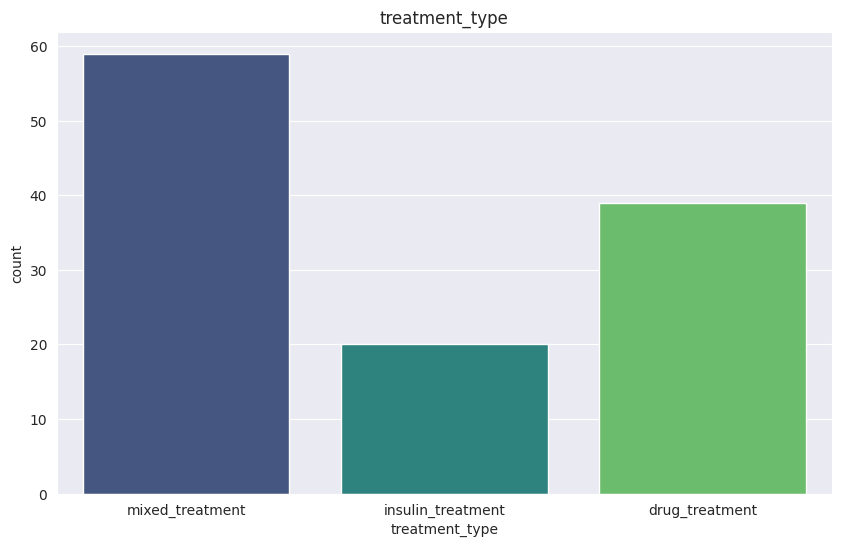

In [84]:
plt.figure(figsize=(10, 6))
sns.countplot(x='treatment_type', hue='treatment_type', data=df, palette='viridis')
plt.title('treatment_type')
plt.show()

# PREDICTIVE ANALYSIS

In [85]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [
            'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)', 'Smoking History (pack year)',
            'Duration of Diabetes (years)', 'Fasting Plasma Glucose (mg/dl)',
            '2-hour Postprandial Plasma Glucose (mg/dl)',
            'Fasting C-peptide (nmol/L)', '2-hour Postprandial C-peptide (nmol/L)', 'Fasting Insulin (pmol/L)',
            '2-hour Postprandial Insulin (pmol/L)', 'HbA1c (mmol/mol)', 'Glycated Albumin (%)',
            'Total Cholesterol (mmol/L)',
            'Triglyceride (mmol/L)', 'High-Density Lipoprotein Cholesterol (mmol/L)',
            'Low-Density Lipoprotein Cholesterol (mmol/L)', 'Creatinine (umol/L)',
            'Estimated Glomerular Filtration Rate  (ml/min/1.73m2)', 'Uric Acid (mmol/L)',
            'Blood Urea Nitrogen (mmol/L)'
        ]),
        ('bin', 'passthrough',
         ['Gender (Female=1, Male=2)', 'has_hypoglycemia', 'Alcohol Drinking History (drinker/non-drinker)',
          'Type of Diabetes'
          ])
    ]
)

X = df.drop('treatment_type', axis=1)
y = df['treatment_type']

In [86]:
df.shape

(118, 28)

In [87]:
df.head()

,Patient Number,"Gender (Female=1, Male=2)",Age (years),Height (m),Weight (kg),BMI (kg/m2),Smoking History (pack year),Alcohol Drinking History (drinker/non-drinker),Type of Diabetes,Duration of Diabetes (years),...,Total Cholesterol (mmol/L),Triglyceride (mmol/L),High-Density Lipoprotein Cholesterol (mmol/L),Low-Density Lipoprotein Cholesterol (mmol/L),Creatinine (umol/L),Estimated Glomerular Filtration Rate (ml/min/1.73m2),Uric Acid (mmol/L),Blood Urea Nitrogen (mmol/L),has_hypoglycemia,treatment_type
0,1001_0_20210730,1,66,1.5,60,26.67,0.0,1,0,10.00,...,3.59,1.02,0.86,2.01,37.3,160.0,188.86,6.47,0,mixed_treatment
1,1002_0_20210504,2,68,1.7,63,21.80,50.0,0,0,26.00,...,4.78,2.20,0.93,3.28,66.8,109.0,342.57,6.05,1,insulin_treatment
2,1002_1_20210521,2,68,1.7,67,23.18,50.0,0,0,26.00,...,4.78,2.20,0.93,3.28,69.4,104.0,322.18,3.06,1,insulin_treatment
3,1002_2_20210909,2,68,1.7,65,22.49,50.0,0,0,26.00,...,3.49,1.82,0.84,1.83,63.7,115.0,342.34,6.21,1,insulin_treatment
4,1003_0_20210831,2,37,1.9,60,16.62,0.0,1,0,0.08,...,5.61,1.14,1.08,3.95,49.6,174.0,93.39,1.85,1,mixed_treatment


# Create Pipeline / predict and evaluate

## RFC

In [143]:
# from sklearn.multiclass import OneVsRestClassifier

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [144]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [145]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print('best parameters: ', grid_search.best_params_)

best parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}


In [137]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.75
                   precision    recall  f1-score   support

   drug_treatment       0.89      0.89      0.89         9
insulin_treatment       0.33      0.33      0.33         3
  mixed_treatment       0.75      0.75      0.75        12

         accuracy                           0.75        24
        macro avg       0.66      0.66      0.66        24
     weighted avg       0.75      0.75      0.75        24



In [127]:
import numpy as np

print("unique y_test:", np.unique(y_test))
print("unique y_pred:", np.unique(y_pred))

unique y_test: ['drug_treatment' 'insulin_treatment' 'mixed_treatment']
unique y_pred: ['drug_treatment' 'insulin_treatment' 'mixed_treatment']


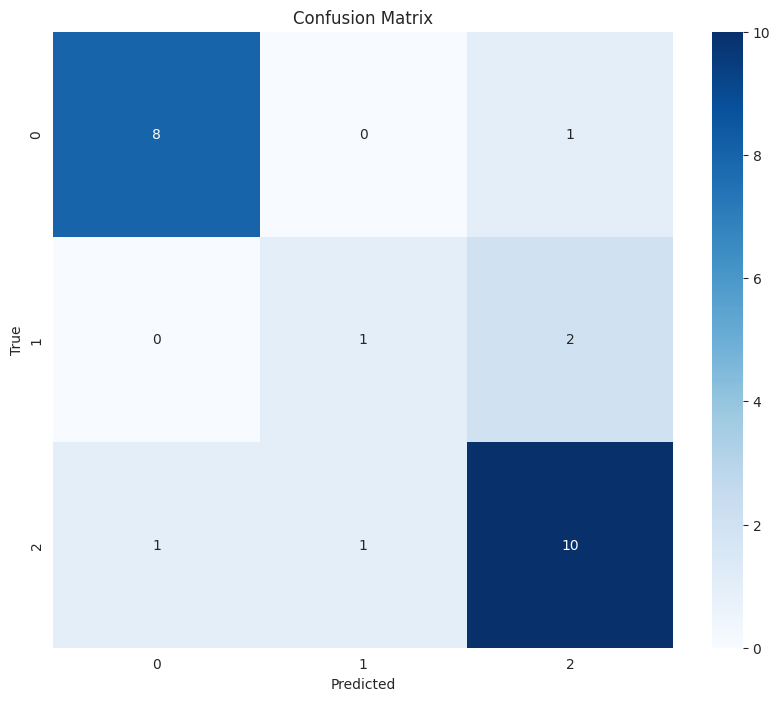

In [128]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [94]:
print(sorted(y.unique()))

['drug_treatment', 'insulin_treatment', 'mixed_treatment']


### DTC

In [95]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

In [96]:
param_grid = {
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_depth': [10, 20, 30],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_leaf_nodes': [10, 20, 50],
}

In [97]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__criterion': 'gini', 'classifier__max_depth': 30, 'classifier__max_features': 'log2', 'classifier__max_leaf_nodes': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


In [98]:
y_pred = grid_search.predict(X_test)
print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.5416666666666666
                   precision    recall  f1-score   support

   drug_treatment       0.75      1.00      0.86         9
insulin_treatment       0.00      0.00      0.00         3
  mixed_treatment       0.67      0.33      0.44        12

         accuracy                           0.54        24
        macro avg       0.47      0.44      0.43        24
     weighted avg       0.61      0.54      0.54        24



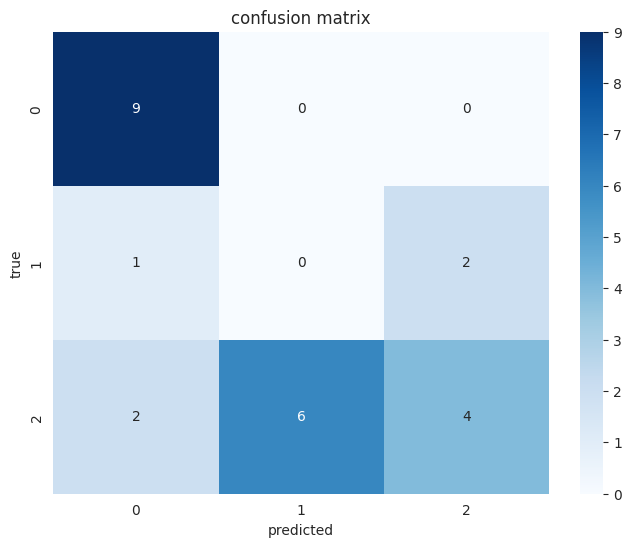

In [99]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

## KNN

In [100]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]
)

In [101]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2],
    'classifier__weights': ['uniform', 'distance'],
}

In [102]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__p': 1, 'classifier__weights': 'distance'}


In [103]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.5416666666666666
                   precision    recall  f1-score   support

   drug_treatment       0.50      0.89      0.64         9
insulin_treatment       0.00      0.00      0.00         3
  mixed_treatment       0.62      0.42      0.50        12

         accuracy                           0.54        24
        macro avg       0.38      0.44      0.38        24
     weighted avg       0.50      0.54      0.49        24



/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

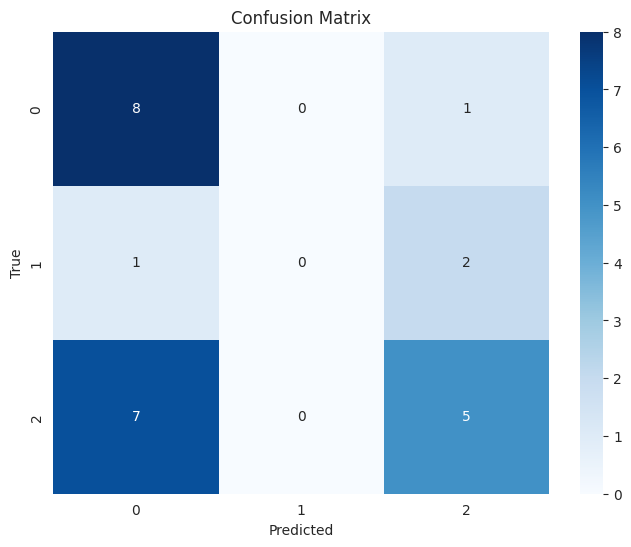

In [104]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## LR

In [105]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]
)

In [106]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': [300, 500, 1000]
}

In [107]:
grid_search = GridSearchCV(clf, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print('best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenv

best parameters {'classifier__C': 1, 'classifier__max_iter': 300, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/semyon/.local/share/virtualenv

In [108]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


model accuracy 0.75
                   precision    recall  f1-score   support

   drug_treatment       0.82      1.00      0.90         9
insulin_treatment       0.33      0.33      0.33         3
  mixed_treatment       0.80      0.67      0.73        12

         accuracy                           0.75        24
        macro avg       0.65      0.67      0.65        24
     weighted avg       0.75      0.75      0.74        24



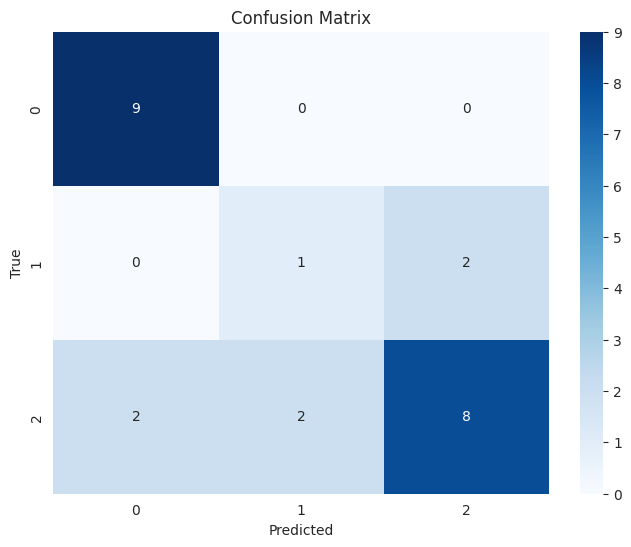

In [109]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## XGBoost

In [110]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier())
    ]
)

In [111]:
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200],
    'classifier__subsample': [0.8, 1.0],
}

In [112]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

best parameters {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


In [113]:
y_pred = grid_search.predict(X_test)

print('model accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy 0.6666666666666666
              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.33      0.33      0.33         3
           2       0.70      0.58      0.64        12

    accuracy                           0.67        24
   macro avg       0.59      0.60      0.59        24
weighted avg       0.66      0.67      0.66        24



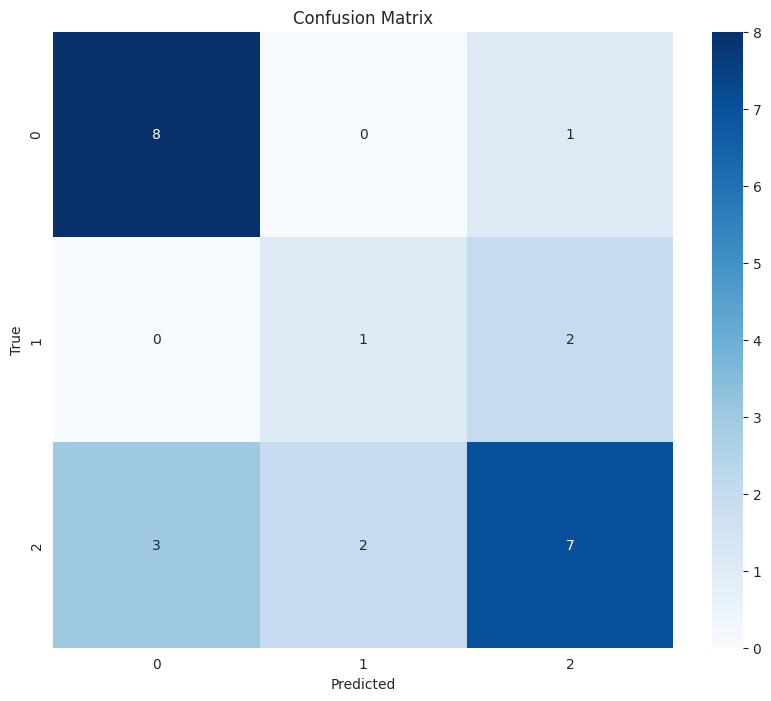

In [114]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Lightgbm

In [115]:
clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(verbose=-1))
    ]
   )

In [116]:
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [15, 31],
    'classifier__min_child_samples': [10, 20, 30],
}

In [117]:
grid_search = GridSearchCV(clf, param_grid, cv=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)
print('best parameters', grid_search.best_params_)

/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature

best parameters {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__min_child_samples': 10, 'classifier__n_estimators': 100, 'classifier__num_leaves': 15}


In [118]:
y_pred = grid_search.predict(X_test)

print('model accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

model accuracy:  0.6666666666666666
                   precision    recall  f1-score   support

   drug_treatment       0.73      0.89      0.80         9
insulin_treatment       0.33      0.33      0.33         3
  mixed_treatment       0.70      0.58      0.64        12

         accuracy                           0.67        24
        macro avg       0.59      0.60      0.59        24
     weighted avg       0.66      0.67      0.66        24



/home/semyon/.local/share/virtualenvs/jupyter_insulin-dose-research-3ab3ZZaS/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


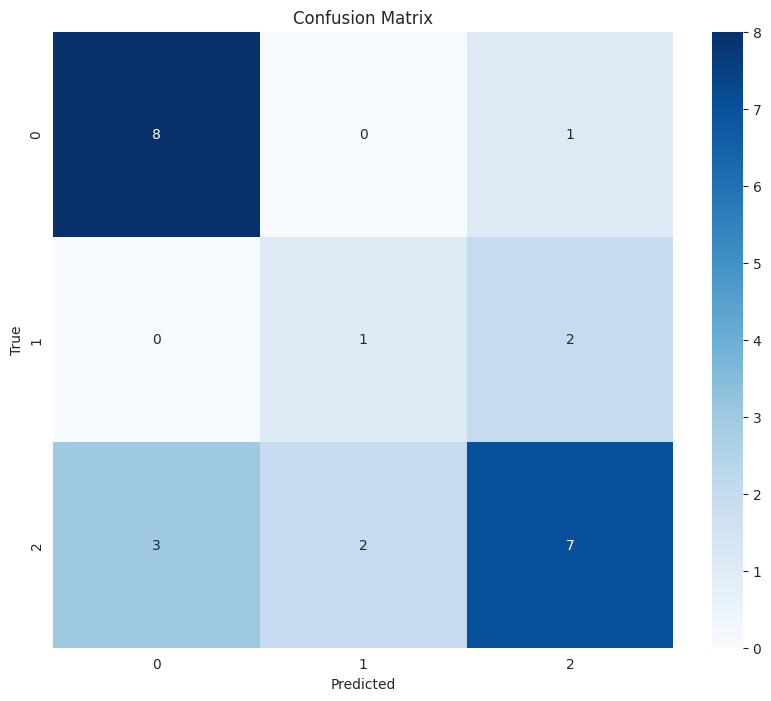

In [119]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()